# Generalized CPGs


## Requirements

First, we import the required libraries. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import grad, jit, vmap

from vector_field import vector_field, utilities

To model the tangential flow, we construct a simple counterclockwise rotational field.

In [2]:
# Defining a general class of functions which define the
# tangential component of the CPG update. 

class SimpleRotationalField(vector_field.VectorField):
    def __init__(self):
        pass 
    def get_gradient(self,x):
        theta = np.arctan2(x[0], x[1])
        return np.array([-np.cos(theta), np.sin(theta)])

## Constructing a basic CPG

Now we're ready to combine the above elements to construct a CPG out of base components. 

In [3]:
square = lambda x: jnp.dot(x, x)
inv_sq = lambda x: 1 / jnp.dot(x, x)
s1 = vector_field.FunctionalPotentialField(square)
s2 = vector_field.FunctionalPotentialField(inv_sq)
s3 = vector_field.LinearCombinationPotentialField([s1, s2])

m = SimpleRotationalField()
d = vector_field.LinearCombinationVectorField([s3, m])

We simulate the CPG update for 100 steps with step size of 0.1

In [4]:
history = utilities.simulate_trajectory(
    d, jnp.array([0.5, 0.5]),
    step_size = 0.1, num_iters = 100)

Lastly, we visualize the resulting trajectory. 
As we can see, we have constructed a system with stable limit cycle at ```x^2 + y^2 = 1```

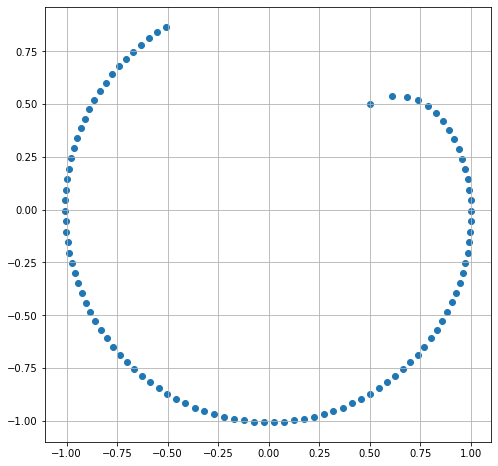

In [5]:
def plot_history(x_history, **subplot_kwargs):
    fig, ax = plt.subplots(**subplot_kwargs)
    ax.scatter(x_history[:,0], x_history[:,1])
    ax.grid(True)

plot_history(history, figsize=(8,8))

## Linear Transformations

We consider linear transformations of 2D space. The transform shown below warps the circle into an ellipse.

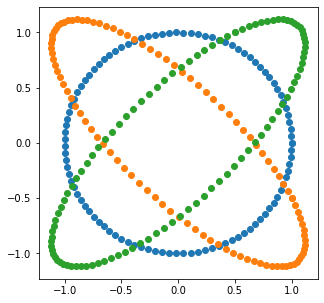

In [6]:
A = jnp.array([[1.0, -0.5],[-0.5, 1.0]])

def scatter_circle_points():
    n = 100
    x = np.zeros((100,2))
    phases = np.linspace(0, 2*np.pi, n)
    for i in range(n):
        x[i] = np.array([np.cos(phases[i]), np.sin(phases[i])])
    return x 

fig, ax = plt.subplots(figsize=(5,5))
circle_points = scatter_circle_points()
ax.scatter(circle_points[:,0], circle_points[:,1])
ellipse_points = circle_points @ A.T
ax.scatter(ellipse_points[:,0], ellipse_points[:,1])
rot_ellipse_points = ellipse_points @ utilities.get_rotational_matrix(np.pi/2).T
ax.scatter(rot_ellipse_points[:,0], rot_ellipse_points[:,1])

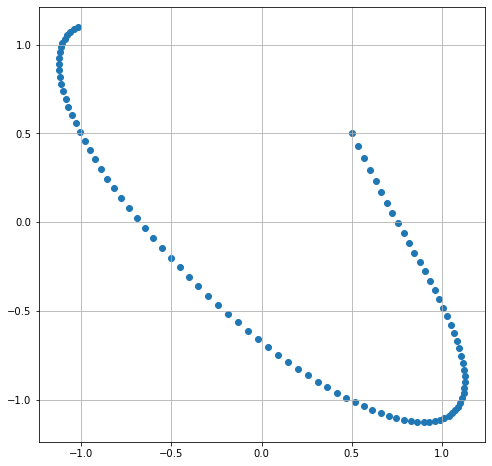

In [7]:
f = lambda x: jnp.linalg.inv(A) @ x
ellipse = vector_field.SmoothTransformationVectorField(d, f)

history = utilities.simulate_trajectory(
    ellipse, jnp.array([0.5, 0.5]),
    step_size = 0.1, num_iters = 100, grad_clip=0.1)
plot_history(history, figsize=(8,8))

We can construct a rotated form of the above elliptical shape with linear transformation as well. 

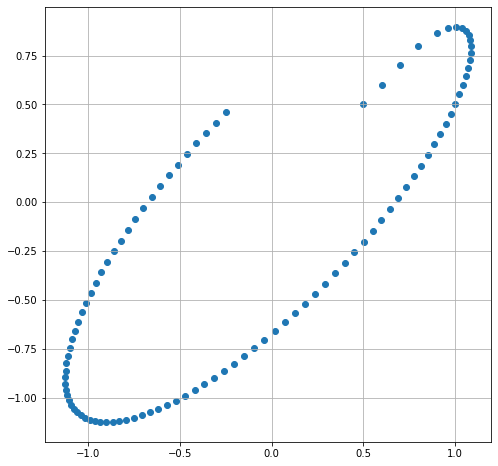

In [8]:
g = lambda x: np.linalg.inv(utilities.get_rotational_matrix(np.pi/2) @ A) @ x
rot_ellipse = vector_field.SmoothTransformationVectorField(d, g)

history = utilities.simulate_trajectory(
    rot_ellipse, jnp.array([0.5, 0.5]),
    step_size = 0.1, num_iters = 100, grad_clip=0.1)
plot_history(history, figsize=(8,8))

We can also visualize the potential fields used to obtain these elliptical limit cycles

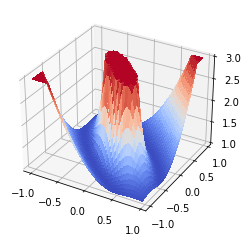

In [9]:
s3_f = vector_field.SmoothTransformationPotentialField(s3, f)
utilities.plot_potential_field(s3_f, jnp.array([-1, 1]), jnp.array([-1, 1]), max_clip = 3)

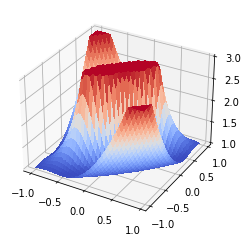

In [10]:
s3_g = vector_field.SmoothTransformationPotentialField(s3, g)
utilities.plot_potential_field(s3_g, jnp.array([-1, 1]), jnp.array([-1, 1]), max_clip = 3)

## Designing A Complex Limit Cycle

With the above building blocks, we can now try to build a dynamical system that exhibits a more complex limit cycle.

By superimposing two elliptical potential fields in a cross-shape and the rotational field previously given, we theorize that we can construct a clover shape. 

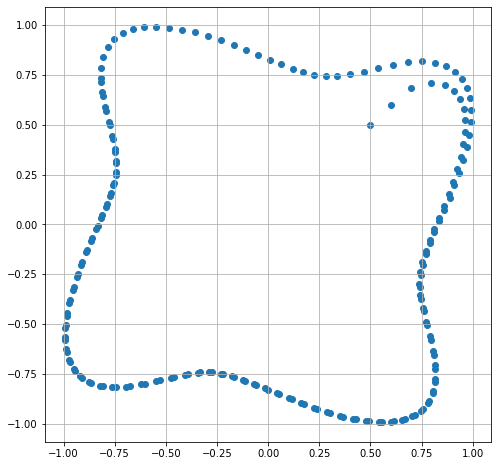

In [11]:
clover = vector_field.LinearCombinationVectorField(
    [ellipse, rot_ellipse]
)

history = utilities.simulate_trajectory(
    clover, jnp.array([0.5, 0.5]),
    step_size = 0.1, num_iters = 200, grad_clip=0.1)
plot_history(history, figsize=(8,8))

That worked surprisingly well. Overall the shape seems to be 'rotated' slightly from the ideal X-shape. Not entirely sure why that happens but I think it is due to the fact that we generated ```rot_ellipse``` as a 90-degree rotation of ```ellipse``` - some of that rotation is preserved in the linear combination.

Nonetheless, we observe four distinct corners. 

Edit: small investigation into the "skewed" clover shape.

Let's define a "rotational" field with zero rotation, use that to create ```ellipse2```, and look at the linear combination of ```ellipse``` and ```ellipse2```

In [12]:
class ZeroRotationalField(vector_field.VectorField):
    def __init__(self):
        pass 
    def get_gradient(self,x):
        #theta = np.arctan2(x[0], x[1])
        #return np.array([-np.cos(theta), np.sin(theta)])
        return np.array([0, 0])

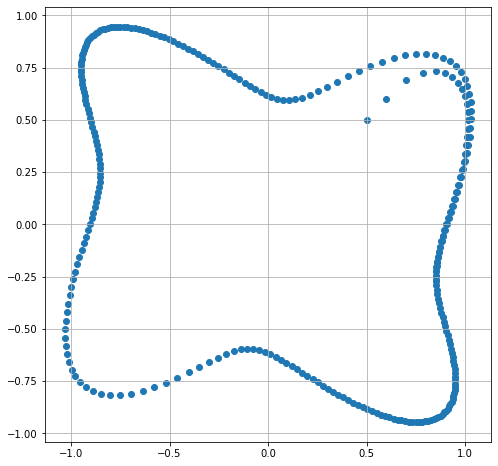

In [13]:
m2 = ZeroRotationalField()
d2 = vector_field.LinearCombinationVectorField([s3, m2])

ellipse2 = vector_field.SmoothTransformationVectorField(d2, g)
clover2 = vector_field.LinearCombinationVectorField([ellipse, ellipse2])

history = utilities.simulate_trajectory(
    clover2, jnp.array([0.5, 0.5]),
    step_size = 0.1, num_iters = 300, grad_clip=0.1)
plot_history(history, figsize=(8,8))

As we can see, the clover is still not "ideal" shaped. The cause of the skewedness in this case is in the rotational field of ```ellipse``` only (since ```ellipse2``` has no rotation). We see how the "width" of ```ellipse2``` at its vertices has increased due to the rotational field of ```ellipse```, whereas the width of ```ellipse``` at its vertices remains the same as before the linear transformation since ```ellipse2``` does not stretch it tangentially to the origin. 

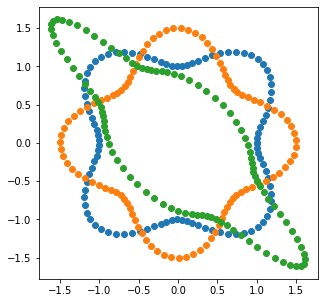

In [14]:
B = utilities.get_rotational_matrix(np.pi/4)
def scatter_clover_points(n = 100):
    # This function creates a clover by using polar coordinates, 
    # inspired by the idea for the general parametrization of limit cycles
    x = np.zeros((n,2))
    phases = np.linspace(0, 2*np.pi, n)
    for i in range(n):
        r = 1 + 0.5*np.power(np.sin(2*phases[i]), 2)
        x[i] = np.array([np.cos(phases[i]) * r, 
                         np.sin(phases[i]) * r]) 
    return x 

# we can plot a clover
fig, ax = plt.subplots(figsize=(5,5))
clover_points = scatter_clover_points()
ax.scatter(clover_points[:,0], clover_points[:,1])
# we can rotate this clover
ellipse_points_c = clover_points @ B.T
ax.scatter(ellipse_points_c[:,0], ellipse_points_c[:,1])
# we can also rotate it and stretch it
ellipse_points_c2 = clover_points @ A.T
ax.scatter(ellipse_points_c2[:,0], ellipse_points_c2[:,1])

Let's try a wider variety of starting conditions. 

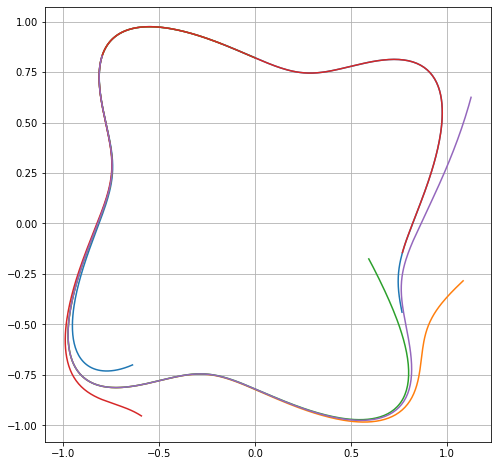

In [15]:
starting_conditions = [
    np.random.uniform(-1.2, 1.2, size = (2)) for i in range(5)
]
x_history = []
for s in starting_conditions:
    history = utilities.simulate_trajectory(
        clover, s,
        step_size = 0.02, num_iters = 400, grad_clip=0.1)
    x_history.append(history)

def plot_histories(x_history, **subplot_kwargs):
    """
    x_history: A list of histories
    """
    fig, ax = plt.subplots(**subplot_kwargs)
    for x_hist in x_history:
        ax.plot(x_hist[:,0], x_hist[:,1])
        ax.grid(True)

plot_histories(x_history, figsize=(8,8))

It's a bit rough but the seeds of something very cool are here. 

## Learning Limit Cycles

So far we have designed functions that warp the state space in some analytic way.Now we want to see if we can learn simple transformations that deform the circular limit cycle into an arbitrary shape, e.g a five-pointed star shape. 

This involves a supervised learning task. Minimally, we need to construct pairs of points on the base and target limit cycles, and learn a smooth (preferably invertible) diffeomorphism between them. 

### Flax

To implement supervised learning, we use the Flax library based on Jax 

In [16]:
import flax
import optax


As a warm-up, let's use points on the limit cycle obtained from our previous construction and pair them with points on the circle (of similar phase). 

To do this, we initialize a trajectory, allow it to converge, and then collect 1000 data points associated with phases. 

The learnable mapping has to be from the desired manifold (here, the clover-shape) to the original manifold (the circle) in order to work with the ```SmoothTransformationVectorField``` defined earlier. 

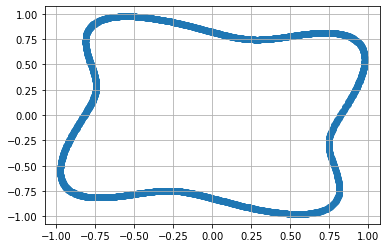

In [17]:
def get_dataset():
    history = utilities.simulate_trajectory(
        clover, np.array([1.0, 1.0]),
        step_size = 0.02, num_iters = 1200, grad_clip=0.1
    )
    # Cut off the off-limit-cycle points
    return history[200:]

features = get_dataset()
plot_history(features)

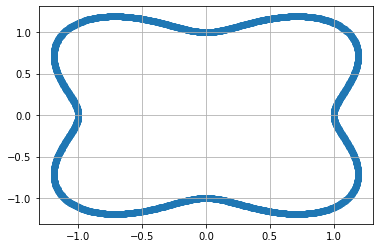

In [78]:
#over-write previous function with actual clover
def get_dataset():
    return scatter_clover_points(n=1000)

features = get_dataset()
plot_history(features)

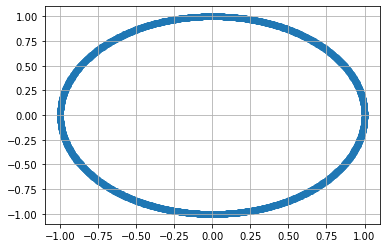

In [60]:
phases = np.arctan2(features[:,0], features[:,1])
targets = np.zeros([1000, 2])
targets[:,0] = np.cos(phases)
targets[:,1] = np.sin(phases)

plot_history(targets)

## Implementing ML in Flax

Adapted from https://flax.readthedocs.io/en/latest/notebooks/annotated_mnist.html

In [61]:
# 5. Define dataset
def get_datasets(features, targets):
    import numpy
    # Split train and val sets
    X_train = features[:800]
    X_test = features[800:]
    y_train = targets[:800]
    y_test = targets[800:]
    
    train_ds = {
        'features': X_train, 
        'targets': y_train
    }
    test_ds = {
        'features': X_test, 
        'targets': y_test,
    }
    return train_ds, test_ds

train_ds, test_ds = get_datasets(features, targets)

In [62]:
import jax
import flax.linen as nn
from flax.training import train_state 

# 2. Define Network
class Net(nn.Module):
    """ Construct a learnable, nonlinear diffeomorphism on R^2"""
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features = 16)(x)
        x = nn.elu(x)
        x = nn.Dense(features = 16)(x)
        x = nn.elu(x)
        x = nn.Dense(features = 2)(x)
        return x

# 3. Define loss
def regression_loss(*, preds, targets):
    return optax.huber_loss(preds, targets).mean()

# 4. Define metrics - TODO
def compute_metrics(*, preds, targets):
    loss = regression_loss(preds=preds, targets=targets)
    metrics = {
        'loss': loss,
    }
    return metrics


# 6. Train state
def create_train_state(rng, learning_rate, momentum):
    net = Net()
    params = net.init(rng, jnp.ones([1, 2]))['params']
    tx = optax.sgd(learning_rate, momentum)
    return train_state.TrainState.create(
        apply_fn=net.apply, params=params, tx=tx)

@jax.jit
def train_step(state, batch):
    """Train for a single step."""
    def loss_fn(params):
        preds = Net().apply({'params': params}, batch['features'])
        loss = regression_loss(preds=preds, targets=batch['targets'])
        return loss, preds
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_, preds), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    metrics = compute_metrics(preds=preds, targets=batch['targets'])
    return state, metrics

@jax.jit
def eval_step(params, batch):
    preds = Net().apply({'params': params}, batch['features'])
    return compute_metrics(preds=preds, targets=batch['targets'])

def train_epoch(state, train_ds, batch_size, epoch, rng):
    """Train for a single epoch."""
    train_ds_size = len(train_ds['features'])
    steps_per_epoch = train_ds_size // batch_size

    perms = jax.random.permutation(rng, train_ds_size)
    perms = perms[:steps_per_epoch * batch_size]  # skip incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size))
    batch_metrics = []
    for perm in perms:
        batch = {k: v[perm, ...] for k, v in train_ds.items()}
        state, metrics = train_step(state, batch)
        batch_metrics.append(metrics)

    # compute mean of metrics across each batch in epoch.
    batch_metrics_np = jax.device_get(batch_metrics)
    epoch_metrics_np = {
        k: np.mean([metrics[k] for metrics in batch_metrics_np])
        for k in batch_metrics_np[0]}

    print('train epoch: %d, loss: %.4f ' % (
        epoch, epoch_metrics_np['loss']))

    return state

def eval_model(params, test_ds):
    metrics = eval_step(params, test_ds)
    metrics = jax.device_get(metrics)
    summary = jax.tree_map(lambda x: x.item(), metrics)
    return summary['loss']

In [67]:
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)
learning_rate = 0.1
momentum = 0.9
state = create_train_state(init_rng, learning_rate, momentum)
del init_rng  # Must not be used anymore.

num_epochs = 250
batch_size = 32

for epoch in range(1, num_epochs + 1):
  # Use a separate PRNG key to permute image data during shuffling
  rng, input_rng = jax.random.split(rng)
  # Run an optimization step over a training batch
  state = train_epoch(state, train_ds, batch_size, epoch, input_rng)
  # Evaluate on the test set after each training epoch 
  test_loss = eval_model(state.params, test_ds)
  print(' test epoch: %d, loss: %.2f ' % (
      epoch, test_loss))

train epoch: 1, loss: 0.0656 
 test epoch: 1, loss: 0.01 
train epoch: 2, loss: 0.0059 
 test epoch: 2, loss: 0.01 
train epoch: 3, loss: 0.0021 
 test epoch: 3, loss: 0.02 
train epoch: 4, loss: 0.0016 
 test epoch: 4, loss: 0.02 
train epoch: 5, loss: 0.0014 
 test epoch: 5, loss: 0.02 
train epoch: 6, loss: 0.0012 
 test epoch: 6, loss: 0.02 
train epoch: 7, loss: 0.0011 
 test epoch: 7, loss: 0.02 
train epoch: 8, loss: 0.0010 
 test epoch: 8, loss: 0.03 
train epoch: 9, loss: 0.0009 
 test epoch: 9, loss: 0.03 
train epoch: 10, loss: 0.0009 
 test epoch: 10, loss: 0.03 
train epoch: 11, loss: 0.0008 
 test epoch: 11, loss: 0.03 
train epoch: 12, loss: 0.0008 
 test epoch: 12, loss: 0.03 
train epoch: 13, loss: 0.0008 
 test epoch: 13, loss: 0.03 
train epoch: 14, loss: 0.0007 
 test epoch: 14, loss: 0.03 
train epoch: 15, loss: 0.0007 
 test epoch: 15, loss: 0.03 
train epoch: 16, loss: 0.0007 
 test epoch: 16, loss: 0.03 
train epoch: 17, loss: 0.0007 
 test epoch: 17, loss: 0.03

train epoch: 178, loss: 0.0001 
 test epoch: 178, loss: 0.02 
train epoch: 179, loss: 0.0001 
 test epoch: 179, loss: 0.02 
train epoch: 180, loss: 0.0001 
 test epoch: 180, loss: 0.02 
train epoch: 181, loss: 0.0001 
 test epoch: 181, loss: 0.02 
train epoch: 182, loss: 0.0001 
 test epoch: 182, loss: 0.02 
train epoch: 183, loss: 0.0000 
 test epoch: 183, loss: 0.02 
train epoch: 184, loss: 0.0001 
 test epoch: 184, loss: 0.02 
train epoch: 185, loss: 0.0001 
 test epoch: 185, loss: 0.02 
train epoch: 186, loss: 0.0001 
 test epoch: 186, loss: 0.02 
train epoch: 187, loss: 0.0000 
 test epoch: 187, loss: 0.02 
train epoch: 188, loss: 0.0000 
 test epoch: 188, loss: 0.02 
train epoch: 189, loss: 0.0000 
 test epoch: 189, loss: 0.02 
train epoch: 190, loss: 0.0001 
 test epoch: 190, loss: 0.02 
train epoch: 191, loss: 0.0000 
 test epoch: 191, loss: 0.02 
train epoch: 192, loss: 0.0000 
 test epoch: 192, loss: 0.02 
train epoch: 193, loss: 0.0000 
 test epoch: 193, loss: 0.02 
train ep

Let's visualize the quality of the predictions on the train and test set. 

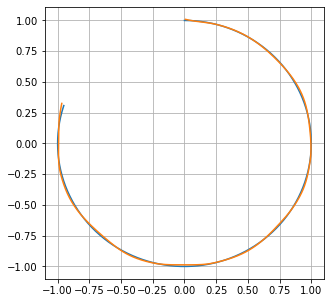

In [64]:
@jax.jit 
def predict(params, batch):
    preds = Net().apply({'params': params}, batch['features'])
    return preds

preds = predict(state.params, train_ds)
targets = train_ds['targets']
plot_histories(
    [targets, preds], figsize=(5,5)
)

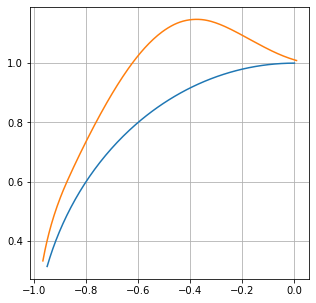

In [65]:
preds = predict(state.params, test_ds)
targets = test_ds['targets']
plot_histories(
    [targets, preds], figsize=(5,5)
)

Now let's visualize the resultant dynamical system induced by applying this learned mapping to the circle. 

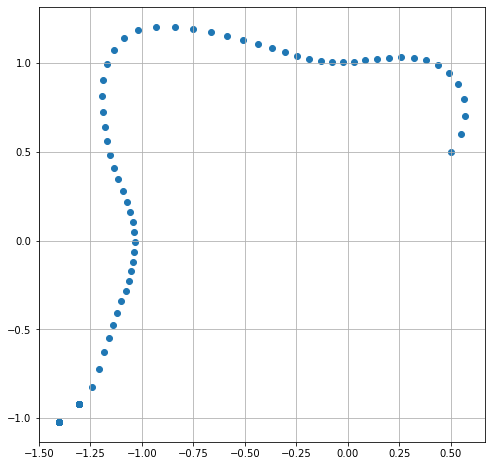

In [77]:
params = state.params

h = lambda x: Net().apply({'params': params}, x)

nn_dyn_sys = vector_field.SmoothTransformationVectorField(d, h)

history = utilities.simulate_trajectory(
    nn_dyn_sys, jnp.array([0.5, 0.5]),
    step_size = 0.1, num_iters = 200, grad_clip=0.1)
plot_history(history, figsize=(8,8))

Interestingly, if we modify the gradient clipping value, we can now close the loop of the cycle, albeit with some artifacts on the lower left corner of the clover

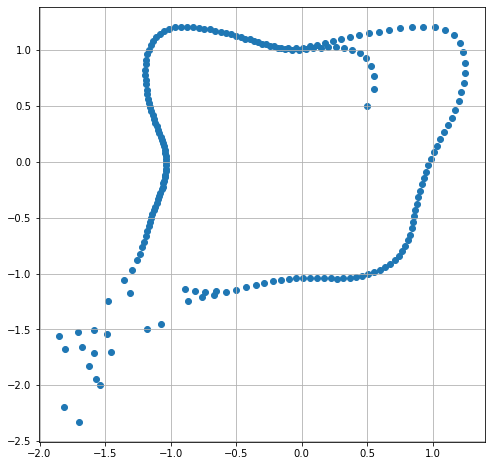

In [81]:
params = state.params

h = lambda x: Net().apply({'params': params}, x)

nn_dyn_sys = vector_field.SmoothTransformationVectorField(d, h)

history = utilities.simulate_trajectory(
    nn_dyn_sys, jnp.array([0.5, 0.5]),
    step_size = 0.1, num_iters = 200, grad_clip=0.5)
plot_history(history, figsize=(8,8))